In [1]:
#But sometimes people are willing to accept answers provided within certain timeframe,
#so then the question comes down to choosing between answers provided by different users.
#so say a user is willing to accept answers provided within one week, how to distinguish answers?
#how many answers provided by expert vs. others (so there is maximum likelihood to solve the question)? 

import random
import os
import dill
import operator
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import unicodedata
from datetime import datetime
import networkx as nx

os.chdir('/home/vagrant/projects/stackoverflow-post')
network = dill.load(open('data/subnetwork.pkd', 'r'))
G = dill.load(open('data/G.pkd', 'r'))
centrality = dill.load(open('data/centrality.pkd', 'r'))

In [67]:
# names = ['source', 'target', 'time']
# network = pd.read_csv('data/sx-stackoverflow-a2q.txt', sep = ' ', header=None,  names = names) #only focus on answers to questions now
# dill.dump(network, open('data/network.pkd', 'w'))
# df.describe()
# nodes

In [36]:
nodes = np.unique(np.concatenate((network.OwnerUserId.unique(), network.ParentId.unique())))
edges = network.apply(lambda row: (row['OwnerUserId'], row['ParentId']) if int(row['PostTypeId']) == 2 else None, axis = 1)
#save as nodes to put into app
userid = []
for i in nodes:
    if (type(i) == unicode):
        userid.append(unicodedata.normalize('NFKD', i).encode('ascii', 'ignore'))
    else:
        userid.append(i)
pd.DataFrame(userid).to_csv('data/nodes.csv')

In [37]:
edges = list(edges.dropna())
nodes = list(pd.Series(nodes).dropna())

In [38]:
G=nx.MultiDiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
dill.dump(G, open('data/G.pkd', 'w'))

In [39]:
G.__len__()

146470

In [40]:
dg = pd.Series([G.degree(node) for node in nodes], name = 'degree', index = nodes)
idg = pd.Series([G.in_degree(node) for node in nodes], name = 'in degree', index = nodes)
odg = pd.Series([G.out_degree(node) for node in nodes], name = 'out degree', index = nodes)
dc = pd.Series(nx.degree_centrality(G), name = 'degree centrality', index = nodes)
idc = pd.Series(nx.in_degree_centrality(G),name = 'in degree centrality', index = nodes)
odc = pd.Series(nx.out_degree_centrality(G),name = 'out degree centrality', index = nodes)

In [41]:
centrality = pd.concat([dg, idg, odg, dc, idc, odc], axis = 1)
dill.dump(centrality, open('data/centrality.pkd', 'w'))

In [42]:
centrality.sort_values(by='degree centrality', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality
22656,2616,0,2616,0.017860,0.000000,0.017860
23354,2050,0,2050,0.013996,0.000000,0.013996
12950,1534,0,1534,0.010473,0.000000,0.010473
3043,1395,0,1395,0.009524,0.000000,0.009524
10661,1105,2,1103,0.007544,0.000014,0.007531


In [43]:
centrality.loc[centrality.degree <= 10, ].sort_values(by = 'degree', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality
244645,10,10,0,0.000068,0.000068,0.000000
189087,10,10,0,0.000068,0.000068,0.000000
230241,10,10,0,0.000068,0.000068,0.000000
40361,10,5,5,0.000068,0.000034,0.000034
289329,10,10,0,0.000068,0.000068,0.000000


In [44]:
def addNNeighbors(node):
    allNeighbor = len([i for i in nx.all_neighbors(G, node)])
    outNeighbor = len(nx.neighbors(G, node))
    inNeighbor = allNeighbor - outNeighbor
    return {'allN': allNeighbor, 'outN': outNeighbor, 'inN':inNeighbor};

centrality['allN'] = pd.Series(centrality.apply(lambda row: addNNeighbors(row.name)['allN'], axis = 1))
centrality['outN'] = pd.Series(centrality.apply(lambda row: addNNeighbors(row.name)['outN'], axis = 1))
centrality['inN'] = pd.Series(centrality.apply(lambda row: addNNeighbors(row.name)['inN'], axis = 1))
centrality['avg_n_contact'] = centrality['degree']/centrality['allN']
centrality['avg_n_in_contact'] = centrality['in degree']/centrality['inN']
centrality['avg_n_out_contact'] = centrality['out degree']/centrality['outN']

In [45]:
centrality.sort_values(by='avg_n_contact', ascending = False).head() #max is 7 interactions per user with the same other person

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
528519,7,7,0,0.000048,0.000048,0.000000,1,0,1,7.000000,7.000000,NaN
Kociub,6,0,6,0.000041,0.000000,0.000041,1,1,0,6.000000,NaN,6.0
Mike Moyle,10,0,10,0.000068,0.000000,0.000068,2,2,0,5.000000,NaN,5.0
211216,13,13,0,0.000089,0.000089,0.000000,3,0,3,4.333333,4.333333,NaN
209778,21,21,0,0.000143,0.000143,0.000000,5,0,5,4.200000,4.200000,NaN


In [5]:
nx.__version__

'1.11'

/opt/conda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/conda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/conda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


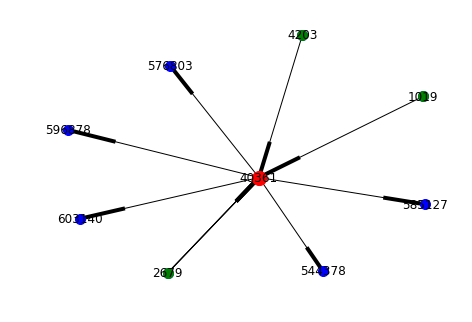

In [3]:
neighbors = [i for i in nx.all_neighbors(G, '40361')] 
# neighbors #8 neighbors but degree = 10, degree takes into account of multiple edges
# len(nx.neighbors(G, '40361')) #number of neighbors for out degree
# len(neighbors) - len(nx.neighbors(G, '40361'))#number of neighbors for in degree
ego = nx.ego_graph(G, '40361', undirected = True)
pos = nx.spring_layout(ego)
nx.draw(ego, pos, node_color='b', node_size = 100, with_labels = True)
nx.draw_networkx_nodes(ego, pos, nodelist = ['40361'], node_size = 200, node_color='r')
nx.draw_networkx_nodes(ego, pos, nodelist = ['1019', '4203', '2679'], node_size = 100, node_color='g')
# nx.draw_networkx_edge_labels(ego, pos, edge_labels = )
plt.figure(figsize=(100,350))
plt.savefig('ego.png')
plt.show()

In [47]:
dill.dump(centrality, open('data/centrality.pkd', 'w'))

In [9]:
#use this to verify merging with main dataframe
centrality.loc[centrality.degree <= 30, ].sort_values(by = 'degree', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
14788,30,0,30,0.000205,0.000000,0.000205,30,30,0,1.0,NaN,1.0
62237,30,0,30,0.000205,0.000000,0.000205,30,30,0,1.0,NaN,1.0
2441,30,0,30,0.000205,0.000000,0.000205,30,30,0,1.0,NaN,1.0
8768,30,0,30,0.000205,0.000000,0.000205,30,30,0,1.0,NaN,1.0
972,30,5,25,0.000205,0.000034,0.000171,30,25,5,1.0,1.0,1.0
